MSE(approx vs raw) = 41.801372
MSE(pred   vs raw) = 27.173135


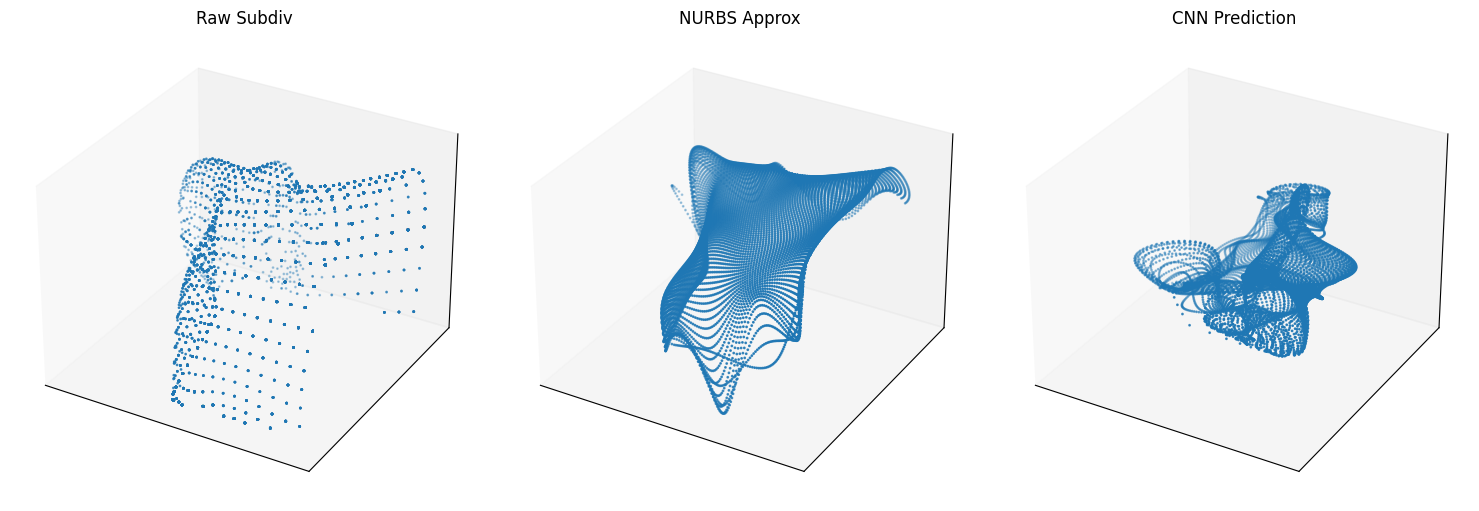

In [6]:
import os
# ─ Force TF to use only GPU 2 ─────────────────────────────────────
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

import numpy as np
import matplotlib.pyplot as plt
from geomdl import fitting, NURBS, utilities
from tensorflow.keras.models import load_model
import dataset_subdiv

def compare_patch_with_model(shape_idx, patch_idx, model_path):
    # 1) load control and subdiv meshes + one patch
    v_ctrl, f_ctrl = dataset_subdiv.load_ply(shape_idx, subdiv=False)
    v_sub, _        = dataset_subdiv.load_ply(shape_idx, subdiv=True)
    patches         = dataset_subdiv.segment_patches(f_ctrl, size=8)
    pf              = patches[patch_idx]

    # 2) build raw 100×100 grid by NN in PCA‐UV
    v_idxs = sorted({vi for fi in pf for vi in f_ctrl[fi]})
    v_patch = v_ctrl[v_idxs]
    mn, mx  = v_patch.min(axis=0), v_patch.max(axis=0)
    sub_pts = v_sub[np.all((v_sub>=mn)&(v_sub<=mx),axis=1)]
    X = sub_pts - sub_pts.mean(axis=0)
    _,_,Vt = np.linalg.svd(X, full_matrices=False)
    uv = X.dot(Vt[:2].T)
    uv = (uv - uv.min(axis=0))/uv.ptp(axis=0)
    U, V = uv[:,0], uv[:,1]

    nu = nv = 100
    us = np.linspace(0,1,nu)
    vs = np.linspace(0,1,nv)
    raw = np.zeros((nu,nv,3),dtype=np.float32)
    for i,u in enumerate(us):
        for j,v in enumerate(vs):
            k = np.argmin((U-u)**2 + (V-v)**2)
            raw[i,j] = sub_pts[k]

    # 3) get your “ground‐truth” NURBS approximation (100×100 grid)
    approx, _ = dataset_subdiv.convert_patch(v_ctrl, f_ctrl, v_sub, pf, viz=False)

    # 4) CNN prediction → control‐net → sample as NURBS
    model = load_model(model_path)
    pred_net = model.predict(raw[None], verbose=0)[0]   # shape (u,v,3)

    from surface_compare import remove_padding_and_shrink_control_net
    pred_net = remove_padding_and_shrink_control_net(
        pred_net,
        threshold=10,
        padding_value=-10,
        padding_tol=20
    )

    # rebuild & sample NURBS from the cleaned net
    surf = NURBS.Surface()
    surf.degree_u = 3
    surf.degree_v = 3
    cu, cv, _ = pred_net.shape
    surf.ctrlpts_size_u = cu
    surf.ctrlpts_size_v = cv
    surf.ctrlpts = pred_net.reshape(-1,3).tolist()
    surf.knotvector_u = utilities.generate_knot_vector(surf.degree_u, cu)
    surf.knotvector_v = utilities.generate_knot_vector(surf.degree_v, cv)

    pred, _ = dataset_subdiv.sample_nurbs(surf, nu=100, nv=100)

    # 5) compute MSEs
    mse_approx = np.mean((raw - approx)**2)
    mse_pred   = np.mean((raw - pred)  **2)
    print(f"MSE(approx vs raw) = {mse_approx:.6f}")
    print(f"MSE(pred   vs raw) = {mse_pred:.6f}")

    # 6) visualize
    fig = plt.figure(figsize=(15,5))
    for ax_idx,(grid,title) in enumerate(zip(
        (raw, approx, pred),
        ("Raw Subdiv", "NURBS Approx", "CNN Prediction")
    )):
        ax = fig.add_subplot(1,3,ax_idx+1, projection='3d')
        pts = grid.reshape(-1,3)
        ax.scatter(pts[:,0], pts[:,1], pts[:,2], s=1)
        ax.set_title(title)
        ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])
    plt.tight_layout()
    plt.show()

# Example: compare patch 0 of shape 25
compare_patch_with_model(
    shape_idx=25,
    patch_idx=0,
    model_path="models/incept_surface_2804_0400_2000ep_94.9412.keras"
)


2025-04-28 12:33:11.060487: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-28 12:33:11.115352: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-28 12:33:13.297924: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22808 MB memory:  -> device: 0, name: NVIDIA TITAN RTX, pci bus id: 0000:60:00.0, compute capability: 7.5
2025-04-28 12:33:31.340469: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8907


Per‐patch MSE (approx, pred):
 patch 00: approx=44.5804, pred=302.8995
 patch 01: approx=7.4094, pred=56.0797

Global MSE over shape 546:
  NURBS Approx vs Raw = 25.994874
  CNN Prediction vs Raw = 179.489604


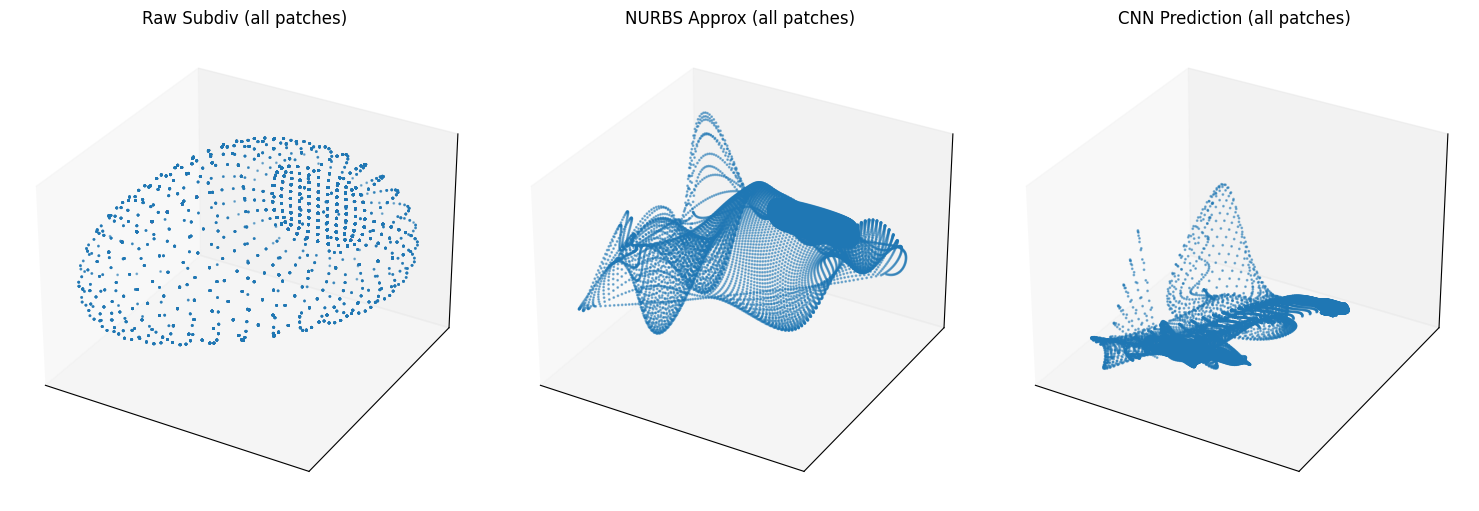

In [1]:
import os
# Force TF to use only GPU 2
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

import numpy as np
import matplotlib.pyplot as plt
from geomdl import NURBS, utilities
from tensorflow.keras.models import load_model
import dataset_subdiv
from surface_compare import remove_padding_and_shrink_control_net

def compare_shape_with_model(shape_idx, model_path):
    # 1) load meshes
    v_ctrl, f_ctrl = dataset_subdiv.load_ply(shape_idx, subdiv=False)
    v_sub, _       = dataset_subdiv.load_ply(shape_idx, subdiv=True)
    patches        = dataset_subdiv.segment_patches(f_ctrl, size=8)

    # load CNN
    model = load_model(model_path)

    per_patch_mse = []
    raw_all, approx_all, pred_all = [], [], []

    for pi, pf in enumerate(patches):
        # --- build raw subdiv grid ---
        v_idxs = sorted({vi for fi in pf for vi in f_ctrl[fi]})
        v_patch = v_ctrl[v_idxs]
        mn, mx  = v_patch.min(axis=0), v_patch.max(axis=0)
        sub_pts = v_sub[np.all((v_sub>=mn)&(v_sub<=mx), axis=1)]
        if len(sub_pts)<4:
            continue
        X = sub_pts - sub_pts.mean(axis=0)
        _,_,Vt = np.linalg.svd(X, full_matrices=False)
        uv = X.dot(Vt[:2].T)
        uv = (uv-uv.min(0))/uv.ptp(0)
        U,V = uv[:,0], uv[:,1]
        nu=nv=100
        us = np.linspace(0,1,nu); vs = np.linspace(0,1,nv)
        raw = np.zeros((nu,nv,3),dtype=np.float32)
        for i,u in enumerate(us):
            for j,v in enumerate(vs):
                k = np.argmin((U-u)**2 + (V-v)**2)
                raw[i,j] = sub_pts[k]

        # --- NURBS ground truth ---
        approx, _ = dataset_subdiv.convert_patch(
            v_ctrl, f_ctrl, v_sub, pf, viz=False
        )

        # --- CNN prediction ---
        pred_net = model.predict(raw[None], verbose=0)[0]
        pred_net = remove_padding_and_shrink_control_net(
            pred_net, threshold=10, padding_value=-10, padding_tol=20
        )
        surf = NURBS.Surface()
        surf.degree_u = 3; surf.degree_v = 3
        cu, cv, _ = pred_net.shape
        surf.ctrlpts_size_u = cu; surf.ctrlpts_size_v = cv
        surf.ctrlpts = pred_net.reshape(-1,3).tolist()
        surf.knotvector_u = utilities.generate_knot_vector(surf.degree_u, cu)
        surf.knotvector_v = utilities.generate_knot_vector(surf.degree_v, cv)
        pred, _ = dataset_subdiv.sample_nurbs(surf, nu=100, nv=100)

        # --- compute MSEs ---
        mse_approx = np.mean((raw - approx)**2)
        mse_pred   = np.mean((raw - pred)**2)
        per_patch_mse.append((mse_approx, mse_pred))

        raw_all.append(raw.reshape(-1,3))
        approx_all.append(approx.reshape(-1,3))
        pred_all.append(pred.reshape(-1,3))

    raw_all   = np.concatenate(raw_all,   axis=0)
    approx_all= np.concatenate(approx_all,axis=0)
    pred_all  = np.concatenate(pred_all,  axis=0)

    global_mse_approx = np.mean((raw_all - approx_all)**2)
    global_mse_pred   = np.mean((raw_all - pred_all)**2)

    print(f"Per‐patch MSE (approx, pred):")
    for i,(ma,mp) in enumerate(per_patch_mse):
        print(f" patch {i:02d}: approx={ma:.4f}, pred={mp:.4f}")
    print(f"\nGlobal MSE over shape {shape_idx}:")
    print(f"  NURBS Approx vs Raw = {global_mse_approx:.6f}")
    print(f"  CNN Prediction vs Raw = {global_mse_pred:.6f}\n")

    # --- visualize full‐shape overlays ---
    fig = plt.figure(figsize=(15,5))
    for ax_idx,(data,title) in enumerate([
        (raw_all,   "Raw Subdiv (all patches)"),
        (approx_all,"NURBS Approx (all patches)"),
        (pred_all,  "CNN Prediction (all patches)")
    ]):
        ax = fig.add_subplot(1,3,ax_idx+1, projection='3d')
        pts = data
        ax.scatter(pts[:,0], pts[:,1], pts[:,2], s=1, alpha=0.5)
        ax.set_title(title)
        ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])
    plt.tight_layout(); plt.show()

# Example usage:
compare_shape_with_model(
    shape_idx=546,
    model_path="models/incept_surface_2804_0400_2000ep_94.9412.keras"
)


In [2]:
!pip install shapely

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 28.3 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


Largest rectangle area: 205.00 units²


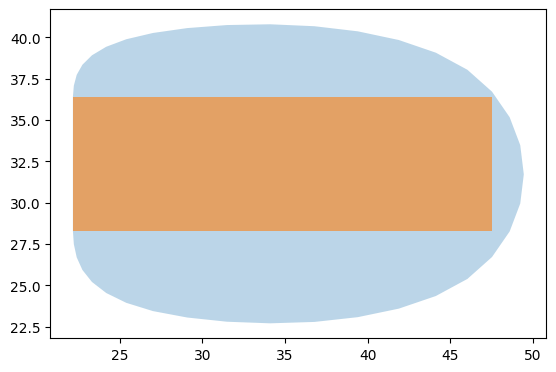

In [3]:
# --- install deps once (skip if already installed) ---
# !pip install shapely matplotlib

# --- minimal demo ------------------------------------------------------------
from mesh_subdivider import load_ply, mesh_footprint, largest_axis_aligned_rectangle, debug_plot

# 1) Load one of your subdivided meshes (change the index!)
verts, faces = load_ply(0, subdiv=True)          # sample000000_subdiv.ply

# 2) Extract its footprint on the XY‑plane
poly = mesh_footprint(verts, faces)

# 3) Find the biggest axis‑aligned rectangle that fits inside
area, rect = largest_axis_aligned_rectangle(poly)
print(f"Largest rectangle area: {area:,.2f} units²")

# 4 (optional) Visual sanity‑check
debug_plot(poly, rect)


In [3]:
!pip install plotly
!pip install trimesh
!pip install rtree


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 543.2/543.2 kB 10.5 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


Volume: 1,583.4396 units³


AttributeError: 'Trimesh' object has no attribute 'faces_unique'

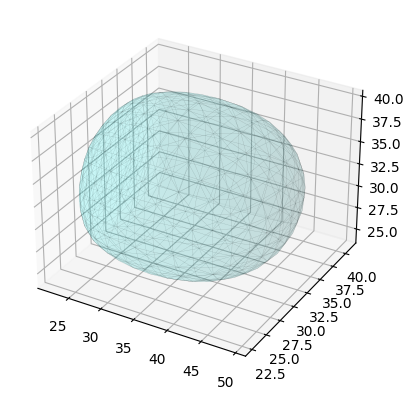

In [3]:
from mesh_subdivider import cuboid_from_ply, cuboid_mesh, debug_plot_voxel
import trimesh

# 1) Get volume + world‑space bounds directly from your dataset index
vol, bounds = cuboid_from_ply(
    0,             # sample000000_subdiv.ply
    subdiv=True,   # default
    pitch=0.03,    # 3 cm voxels; tweak as needed
    max_grid=150   # forwarded to largest_cuboid_voxel
)
print(f"Volume: {vol:,.4f} units³")

# 2) Convert to a trimesh box or visualise
box = cuboid_mesh(bounds)
box.export("largest_cuboid.stl")

debug_plot_voxel(trimesh.load("dataset_1000/sample000000_subdiv.ply"), bounds)


SyntaxError: cannot assign to function call (mesh_subdivider.py, line 201)